In [1]:
!pip install torchinfo tqdm ptflops

# Initial Setup

In [2]:
import os
import gc
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Data Loader Function

This function prepares data loaders for the CIFAR-10 dataset, tailored for use with models like VGG19 that expect RGB images of size 224x224. It includes transformations to adjust the CIFAR-10 grayscale images and create appropriate subsets for training and validation.t.

In [4]:
def get_data_loaders(num_samples=5000, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    train_subset = Subset(train_dataset, range(num_samples))
    val_subset = Subset(test_dataset, range(num_samples // 5))

    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return train_loader, val_loader

### VGG19 Model Preparation Function

This function loads a pre-trained VGG19 model from the ImageNet dataset and modifies its final classification layer to adapt it for a different dataset.

In [5]:
def get_model(classes = 10):
    model = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    model.classifier[6] = nn.Linear(4096, classes)
    return model

### FLOPs Estimation Function
**Returns:**
- `total_flops` (int): The estimated total number of floating-point operations for both the forward and backward passes.

In [6]:
def count_flops(model, input_size=(1, 3, 224, 224)):
    """Estimate FLOPs for the model"""
    total_flops = 0
    for param in model.parameters():
        if len(param.shape) >= 2:
            total_flops += np.prod(param.shape)
    return total_flops * 2

def get_model_file_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / (1024 * 1024)
    os.remove("temp.p")
    return size

### Training Function for One Epoch

This function performs one epoch of training for a given model using the provided data loader, loss function, and optimizer. It includes essential features such as gradient clipping and NaN loss handling to ensure stable and effective training.

**Key Features:**
- **Model Training Mode:** Puts the model in training mode to enable features like dropout and batch normalization.
- **Loss Computation:** Uses the specified criterion (loss function) to calculate the training loss.
- **Gradient Clipping:** Prevents exploding gradients by clipping them to a maximum norm (`max_grad_norm`).
- **NaN Loss Handling:** Detects and skips batches with NaN loss values to maintain training stability.
- **Real-Time Progress Monitoring:** Uses `tqdm` to display real-time progress, including current loss and accuracy.
- **Accuracy Calculation:** Tracks the number of correct predictions to compute accuracy for the epoch.

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Check for NaN loss
        if torch.isnan(loss):
            print("Warning: NaN loss detected. Skipping batch.")
            continue
        
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/total:.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    return running_loss / len(train_loader), 100.*correct/total

### Model Evaluation Function

This function evaluates a trained model on a validation dataset, providing key performance metrics such as loss, accuracy.

**Key Features:**
- **Evaluation Mode:** Sets the model to evaluation mode, disabling features like dropout and batch normalization updates.
- **No Gradient Calculation:** Uses `torch.no_grad()` for efficient evaluation by disabling gradient computations.
- **Top-1 and Top-5 Accuracy:** Computes both standard accuracy (Top-1) and Top-5 accuracy, useful for multi-class classification tasks.

In [8]:
def evaluate(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    correct_top5 = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            
            # Top-1 accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Top-5 accuracy
            _, pred5 = outputs.topk(5, 1, True, True)
            correct_top5 += pred5.eq(targets.view(-1, 1).expand_as(pred5)).sum().item()
    
    return {
        'loss': running_loss / len(val_loader),
        'acc': 100. * correct / total,
        'top1_acc': 100. * correct / total,
        'top5_acc': 100. * correct_top5 / total
    }

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [10]:
def print_and_get_metrics(technique, epoch, metrics, model_size, flops, *args, **kwargs):
    print("\nFinal Model Performance:")
    
    print(f"Result of {technique}:")
    print(f"Total epochs: {epoch}")
    print(f"Model Size: {model_size:.2f} MB")
    print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
    print(f"Accuracy: {metrics['acc']:.2f}%")
    print(f"Top-1 Accuracy: {metrics['top1_acc']:.2f}%")
    print(f"Top-5 Accuracy: {metrics['top5_acc']:.2f}%")
    
    result = {
        "technique": technique,
        "epoch": epoch,
        "model_size": f"{model_size:.2f} MB",
        "flops": f"{flops / 1e9:.2f} GFLOPs",
        "acc": f"{metrics['acc']:.2f}%",
        "top1": f"{metrics['top1_acc']:.2f}%",
        "top5": f"{metrics['top5_acc']:.2f}%",
    }

    for extra in args:
        if isinstance(extra, dict):
            result.update(extra)

    result.update(kwargs)

    return result

# Baseline Model Training

In [11]:
# Configuration
num_epochs=30
batch_size=32
num_samples=5000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Dataset details
print(f"\nDataset Information:")
print(f"Training samples: {num_samples}")
print(f"Validation samples: {num_samples // 5}")
print(f"Batch size: {batch_size}")

Using device: cuda

Dataset Information:
Training samples: 5000
Validation samples: 1000
Batch size: 32


In [12]:
train_loader, val_loader = get_data_loaders(num_samples, batch_size)

100%|██████████| 170M/170M [00:03<00:00, 54.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
def run_baseline(num_epochs, batch_size):
    model = get_model().to(device)
    
    print("\nModel Summary:")
    print(summary(model, input_size=(batch_size, 3, 224, 224)))

    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    flops = count_flops(model)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    
    print("\nStarting training Baseline...")
    epochs_performed = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        eval_metrics = evaluate(model, val_loader, criterion, device)
        val_losses.append(eval_metrics['loss'])
        val_accs.append(eval_metrics['acc'])
        epochs_performed = epochs_performed + 1
        # Early stopping logic
        early_stopping(eval_metrics['loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    model = early_stopping.best_model
    scripted_model = torch.jit.script(model)
    scripted_model.save("baseline_cifar10.pt")

    print("\nPerforming final evaluation for Baseline cifar10...")
    gpu_metrics = evaluate(model, val_loader, criterion, device)
    
    result = print_and_get_metrics("Baseline - CIFAR-10", epochs_performed, gpu_metrics,  model_size, flops)
    
    return model, result, (train_losses, train_accs, val_losses, val_accs)

In [14]:
baseline_cifar10, baseline_result, baseline_metrics = run_baseline(num_epochs, batch_size)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 236MB/s]



Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56

Training: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s, loss=0.053, acc=43.0%]



Epoch 2/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.025, acc=72.7%]



Epoch 3/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.019, acc=79.1%]



Epoch 4/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.015, acc=83.2%]



Epoch 5/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.013, acc=84.8%]



Epoch 6/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.012, acc=86.9%]



Epoch 7/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.010, acc=89.0%]



Epoch 8/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.009, acc=89.7%]



Epoch 9/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.008, acc=90.4%]


EarlyStopping counter: 1 out of 3

Epoch 10/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.007, acc=91.7%]


EarlyStopping counter: 2 out of 3

Epoch 11/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.006, acc=92.6%]


EarlyStopping counter: 3 out of 3
Early stopping triggered

Performing final evaluation for Baseline cifar10...

Final Model Performance:
Result of Baseline - CIFAR-10:
Total epochs: 11
Model Size: 532.57 MB
FLOPs: 0.28 GFLOPs
Accuracy: 86.30%
Top-1 Accuracy: 86.30%
Top-5 Accuracy: 99.80%


# Model Pruning

## Structured Pruning

In [15]:
import torch.nn.utils.prune as prune
from ptflops import get_model_complexity_info

### StructuredPruner Class for Convolutional Neural Networks

The `StructuredPruner` class implements **structured pruning** for convolutional neural networks, focusing on removing entire filters (or channels) based on their importance. This pruning technique reduces model complexity and improves inference speed while minimizing the impact on model performance.

**Key Features:**
- **Filter Importance Scoring:** Uses the **L1-norm** of convolutional filters to measure their importance, prioritizing the removal of less significant filters.
- **Layer-Wise Pruning:** Prunes filters from convolutional layers and adjusts associated batch normalization layers to maintain consistency.
- **Automatic Adjustment of Fully Connected Layers:** After pruning convolutional layers, the class adjusts the first fully connected layer to match the reduced feature map dimensions.
- **Pruning History Tracking:** Records pruning statistics, including the number of filters before and after pruning for each layer.
- **Flexible Pruning Ratio:** Allows users to specify the fraction of filters to prune, providing control over the trade-off between model size and accuracy.

**Benefits of Structured Pruning:**
- **Model Compression:** Reduces the number of parameters and model size for more efficient storage and deployment.
- **Faster Inference:** Decreases computational load, leading to faster inference times, especially on resource-constrained devices.
- **Energy Efficiency:** Reduces power consumption by lowering the number of computations.

**Parameters:**
- `model` (torch.nn.Module): The neural network model to be pruned.

**Methods:**
- `compute_filter_importance(conv_layer)`: Computes the importance score for each filter in a convolutional layer using the L1-norm.
- `prune_conv_layer(conv_layer, bn_layer, prune_ratio)`: Prunes the least important filters from a convolutional layer and adjusts the batch normalization layer if present.
- `prune_model(prune_ratio, input_shape=(3, 224, 224))`: Applies structured pruning across the entire model and adjusts subsequent layers accordingly.
- `_adjust_fc_layer(input_shape)`: Adjusts the first fully connected (FC) layer to match the reduced output size from the convolutional layers after pruning.
- `print_pruning_history()`: Displays a summary of the pruning operations performed on the model.

**Returns:**
- A pruned version of the original model with reduced parameters and computational complexity.

In [16]:
class StructuredPruner:
    def __init__(self, model):
        self.model = model
        self.pruning_history = []
    
    def compute_filter_importance(self, conv_layer):
        """Compute L1-norm of each filter as importance score"""
        weights = conv_layer.weight.data
        importance = torch.sum(torch.abs(weights.view(weights.size(0), -1)), dim=1)
        return importance
    
    def prune_conv_layer(self, conv_layer, bn_layer, prune_ratio):
        n_filters = conv_layer.weight.size(0)
        n_prune = int(n_filters * prune_ratio)
        
        if n_prune == 0:
            return torch.arange(n_filters)  # Return all indices if nothing is pruned
        
        importance = self.compute_filter_importance(conv_layer)
        _, indices = torch.sort(importance)
        indices_to_keep = indices[n_prune:]
        
        # Prune conv layer
        conv_layer.weight.data = torch.index_select(conv_layer.weight.data, 0, indices_to_keep)
        if conv_layer.bias is not None:
            conv_layer.bias.data = torch.index_select(conv_layer.bias.data, 0, indices_to_keep)
        conv_layer.out_channels = len(indices_to_keep)
        
        # Prune batch norm layer if present
        if bn_layer is not None:
            bn_layer.weight.data = torch.index_select(bn_layer.weight.data, 0, indices_to_keep)
            bn_layer.bias.data = torch.index_select(bn_layer.bias.data, 0, indices_to_keep)
            bn_layer.running_mean = torch.index_select(bn_layer.running_mean, 0, indices_to_keep)
            bn_layer.running_var = torch.index_select(bn_layer.running_var, 0, indices_to_keep)
            bn_layer.num_features = len(indices_to_keep)
        
        return indices_to_keep

    def _pre_prune(self):
        self.flops_original, self.params_original = get_model_complexity_info(
            self.model, (3, 224, 224), as_strings=False, print_per_layer_stat=False
        )
        self.flops_original = f"{self.flops_original / 1e9:.2f} GFLOPs"
        self.params_original = f"{self.params_original / 1e6:.2f} Million"
        print(f"Original Model: {self.flops_original}, {self.params_original}")
        
    def _post_prune(self):
        self.flops_pruned, self.params_pruned = get_model_complexity_info(
            self.model, (3, 224, 224), as_strings=False, print_per_layer_stat=False
        )
        
        self.flops_pruned = f"{self.flops_pruned / 1e9:.2f} GFLOPs"
        self.params_pruned = f"{self.params_pruned / 1e6:.2f} Million"
        
        print(f"Pruned Model: {self.flops_pruned}, {self.params_pruned}")
        
    
    def prune_model(self, prune_ratio, input_shape=(3, 224, 224)):
        self._pre_prune()
        prev_indices = None
        
        # Get all conv and batch norm layers
        conv_layers = [module for module in self.model.features if isinstance(module, nn.Conv2d)]
        bn_layers = [module for module in self.model.features if isinstance(module, nn.BatchNorm2d)]
        
        print(f"Found {len(conv_layers)} convolutional layers and {len(bn_layers)} batch norm layers.")
        
        for i, conv in enumerate(conv_layers):
            bn = bn_layers[i] if i < len(bn_layers) else None
            filters_before = conv.weight.size(0)
            
            # Prune current layer
            indices = self.prune_conv_layer(conv, bn, prune_ratio)
            
            # Adjust input channels of next conv layer based on pruned channels
            if prev_indices is not None:
                conv.weight.data = torch.index_select(conv.weight.data, 1, prev_indices)
                conv.in_channels = len(prev_indices)
            
            prev_indices = indices
            
            # Record pruning statistics
            self.pruning_history.append({
                'layer': i,
                'filters_before': filters_before,
                'filters_after': len(indices) if indices is not None else filters_before
            })
        
        # Adjust the first FC layer based on the new conv output
        self._adjust_fc_layer(input_shape)
        self._post_prune()
    
    def _adjust_fc_layer(self, input_shape):
        # Run a dummy input through the model to determine new feature size
        dummy_input = torch.randn(1, *input_shape)
        with torch.no_grad():
            features = self.model.features(dummy_input)
            flattened_size = features.view(1, -1).size(1)
        
        # Update the FC layer to match the new flattened size
        fc = self.model.classifier[0]
        fc.in_features = flattened_size
        fc.weight.data = fc.weight.data[:, :flattened_size]  # Adjust weights
        print(f"Adjusted FC layer input size to: {flattened_size}")

    def get_pruned_stats(self):
        return {
            'flops_original': self.flops_original,
            'flops_pruned': self.flops_pruned,
            'params_original': self.params_original,
            'params_pruned': self.params_pruned
        }
        
    def print_pruning_history(self):
        if not self.pruning_history:
            print("No pruning has been recorded.")
        for entry in self.pruning_history:
            print(f"Layer {entry['layer']}: Filters before = {entry['filters_before']}, Filters after = {entry['filters_after']}")

### VGG19 Model with Structured Pruning

This function initializes a pre-trained **VGG19** model, modifies it for a specified number of classes, and applies **structured pruning** to reduce the model's complexity. The pruning process removes less important filters from convolutional layers, optimizing the model for faster inference and reduced memory usage.

**Key Features:**
- **Pre-trained VGG19 Backbone:** Loads a VGG19 model pre-trained on ImageNet and modifies the final classification layer for the target dataset.
- **Structured Pruning Integration:** Applies structured pruning using the `StructuredPruner` class, which removes less important filters based on their L1-norm importance scores.
- **Customizable Pruning Ratio:** Allows users to define the proportion of filters to prune from each convolutional layer.
- **Pruning History Tracking:** Returns the pruner object, which contains a history of pruning operations, enabling analysis of model modifications.

**Benefits of Structured Pruning:**
- **Model Compression:** Reduces the number of parameters, leading to a smaller model size and faster inference times.
- **Performance Optimization:** Optimized for deployment on resource-constrained devices, such as mobile and embedded systems.
- **Energy Efficiency:** Reduces computational requirements, lowering energy consumption during inference.

In [17]:
def get_model_with_pruning(classes=10, prune_ratio=0.3):
    model = get_model(classes)
    pruner = StructuredPruner(model)
    pruner.prune_model(prune_ratio)
    return model, pruner

In [18]:
def run_structured_pruning(num_epochs, batch_size, prune_ratio=0.3):
    
    model, pruner = get_model_with_pruning(classes=10, prune_ratio=prune_ratio)
    model = model.to(device)
    
    print("\nModel Summary after structured pruning:")
    print(summary(model, input_size=(batch_size, 3, 224, 224)))
    print("\nPruning Statistics:")
    pruner.print_pruning_history()
    stats = pruner.get_pruned_stats()

    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    flops = count_flops(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Training loop
    print("\nStarting training structure pruned model...")
    epochs_performed = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        eval_metrics = evaluate(model, val_loader, criterion, device)
        val_losses.append(eval_metrics['loss'])
        val_accs.append(eval_metrics['acc'])
        epochs_performed = epochs_performed + 1
        early_stopping(eval_metrics['loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
    model = early_stopping.best_model
    scripted_model = torch.jit.script(model)
    scripted_model.save("sp_cifar10.pt")

    print("\nPerforming final evaluation for Structured cifar10...")
    gpu_metrics = evaluate(model, val_loader, criterion, device)
    
    result = print_and_get_metrics(
        "Structured Pruning - CIFAR-10", epochs_performed,
        gpu_metrics, model_size, flops, stats
    )
    gc.collect()
    torch.cuda.empty_cache()
    
    return model, result, (train_losses, train_accs, val_losses, val_accs)

In [19]:
sp_cifar10, sp_result, sp_metrics = run_structured_pruning(num_epochs + 15, batch_size)

Original Model: 19.68 GFLOPs, 139.61 Million
Found 16 convolutional layers and 0 batch norm layers.
Adjusted FC layer input size to: 17591
Pruned Model: 9.77 GFLOPs, 98.73 Million

Model Summary after structured pruning:
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 359, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 45, 224, 224]        1,260
│    └─ReLU: 2-2                         [32, 45, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 45, 224, 224]        18,270
│    └─ReLU: 2-4                         [32, 45, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 45, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 90, 112, 112]        36,540
│    └─ReLU: 2-7                         [32, 90, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 90, 112, 112]    

Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.070, acc=17.2%]



Epoch 2/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.059, acc=30.5%]



Epoch 3/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.053, acc=36.6%]



Epoch 4/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.051, acc=38.3%]



Epoch 5/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.048, acc=40.5%]


EarlyStopping counter: 1 out of 5

Epoch 6/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.046, acc=44.0%]



Epoch 7/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.044, acc=47.9%]



Epoch 8/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.043, acc=50.0%]


EarlyStopping counter: 1 out of 5

Epoch 9/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.041, acc=50.9%]



Epoch 10/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.040, acc=53.6%]



Epoch 11/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.038, acc=56.6%]


EarlyStopping counter: 1 out of 5

Epoch 12/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.036, acc=57.7%]



Epoch 13/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.035, acc=60.0%]



Epoch 14/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.034, acc=60.7%]



Epoch 15/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.033, acc=62.1%]


EarlyStopping counter: 1 out of 5

Epoch 16/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.033, acc=62.6%]


EarlyStopping counter: 2 out of 5

Epoch 17/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.031, acc=64.4%]



Epoch 18/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.031, acc=64.3%]



Epoch 19/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.030, acc=64.8%]


EarlyStopping counter: 1 out of 5

Epoch 20/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.029, acc=67.7%]



Epoch 21/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.028, acc=68.2%]



Epoch 22/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.027, acc=69.4%]


EarlyStopping counter: 1 out of 5

Epoch 23/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.027, acc=68.7%]



Epoch 24/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.026, acc=70.6%]



Epoch 25/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.026, acc=70.4%]



Epoch 26/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.025, acc=71.7%]



Epoch 27/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.024, acc=71.8%]



Epoch 28/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.024, acc=72.8%]


EarlyStopping counter: 1 out of 5

Epoch 29/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.024, acc=72.9%]


EarlyStopping counter: 2 out of 5

Epoch 30/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.023, acc=73.9%]


EarlyStopping counter: 3 out of 5

Epoch 31/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.023, acc=74.6%]



Epoch 32/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.023, acc=74.2%]


EarlyStopping counter: 1 out of 5

Epoch 33/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.022, acc=75.8%]


EarlyStopping counter: 2 out of 5

Epoch 34/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.021, acc=76.6%]


EarlyStopping counter: 3 out of 5

Epoch 35/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.021, acc=77.4%]


EarlyStopping counter: 4 out of 5

Epoch 36/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.020, acc=78.4%]



Epoch 37/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.020, acc=78.0%]


EarlyStopping counter: 1 out of 5

Epoch 38/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.019, acc=78.8%]



Epoch 39/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.69it/s, loss=0.019, acc=79.0%]



Epoch 40/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.018, acc=79.6%]


EarlyStopping counter: 1 out of 5

Epoch 41/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.018, acc=80.1%]



Epoch 42/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.017, acc=80.7%]


EarlyStopping counter: 1 out of 5

Epoch 43/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.017, acc=81.5%]


EarlyStopping counter: 2 out of 5

Epoch 44/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.017, acc=81.6%]


EarlyStopping counter: 3 out of 5

Epoch 45/45


Training: 100%|██████████| 157/157 [00:42<00:00,  3.68it/s, loss=0.017, acc=81.6%]


EarlyStopping counter: 4 out of 5

Performing final evaluation for Structured cifar10...

Final Model Performance:
Result of Structured Pruning - CIFAR-10:
Total epochs: 45
Model Size: 376.64 MB
FLOPs: 0.20 GFLOPs
Accuracy: 71.80%
Top-1 Accuracy: 71.80%
Top-5 Accuracy: 98.10%


## Unstructured Pruning

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

### UnstructuredPruner Class for Neural Network Pruning

The `UnstructuredPruner` class implements **unstructured pruning** for neural networks, which selectively removes individual weights based on their importance (typically by magnitude). This fine-grained pruning method allows for more flexible reduction of model parameters without altering the network's structure.

**Key Features:**
- **L1-Norm Unstructured Pruning:** Prunes weights with the smallest absolute values using **L1-norm** as the criterion, targeting less significant connections.
- **Gradual Pruning:** Supports gradual pruning across multiple steps, incrementally increasing sparsity to reduce the risk of accuracy degradation.
- **Sparsity Tracking:** Calculates and tracks the sparsity (percentage of zero weights) for each pruned layer, providing detailed pruning statistics.
- **Permanent Pruning:** Removes the pruning reparametrization, making the weight removals permanent and reducing computational overhead.
- **Pruning Summary Reporting:** Provides comprehensive statistics, including total parameters, remaining parameters, and overall sparsity.

**Benefits of Unstructured Pruning:**
- **Fine-Grained Control:** Allows selective pruning at the individual weight level, providing greater flexibility compared to structured pruning.
- **Model Compression:** Reduces the number of active parameters, leading to smaller models and faster inference times.
- **Performance Optimization:** Can improve model efficiency, especially on hardware that supports sparse matrix operations.

In [21]:
class UnstructuredPruner:
    def __init__(self, model):
        self.model = model
        self.pruning_stats = {}
    
    def calculate_sparsity(self, module):
        total_params = module.weight.nelement()
        zero_params = torch.sum(module.weight == 0).item()
        return (zero_params / total_params) * 100
    
    def apply_gradual_pruning(self, initial_amount=0.1, final_amount=0.3, steps=3):
        step_amount = (final_amount - initial_amount) / steps
        current_amount = initial_amount
        
        for step in range(steps):
            print(f"\nApplying pruning step {step + 1}/{steps} (amount: {current_amount:.2f})")
            for name, module in self.model.named_modules():
                if isinstance(module, (nn.Conv2d, nn.Linear)):
                    prune.l1_unstructured(module, name='weight', amount=current_amount)
            current_amount += step_amount
            self.update_pruning_stats()
    
    def update_pruning_stats(self):
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                self.pruning_stats[name] = {
                    'sparsity': self.calculate_sparsity(module),
                    'total_params': module.weight.nelement(),
                    'remaining_params': torch.sum(module.weight != 0).item()
                }
    
    def make_permanent(self):
        """Remove pruning reparametrization and make pruning permanent"""
        for module in self.model.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                prune.remove(module, 'weight')
    
    def get_pruning_summary(self):
        total_params = 0
        remaining_params = 0
        
        for stats in self.pruning_stats.values():
            total_params += stats['total_params']
            remaining_params += stats['remaining_params']
        
        return {
            'total_params': total_params,
            'remaining_params': remaining_params,
            'overall_sparsity': ((total_params - remaining_params) / total_params) * 100,
            'layer_stats': self.pruning_stats
        }
        
    def print_stats(self):
        pruning_summary = self.get_pruning_summary()
        print(f"Total parameters: {pruning_summary['total_params']:,}")
        print(f"Remaining parameters: {pruning_summary['remaining_params']:,}")
        pr = f"{((pruning_summary['total_params'] - pruning_summary['remaining_params']) / pruning_summary['total_params'] * 100):.2f}%"
        print(f"Parameters Reduction: {pr}")
        print(f"Overall sparsity: {pruning_summary['overall_sparsity']:.2f}%")
        
        for feature, stats in self.pruning_stats.items():
            print(feature , f": Total params: {stats['total_params']},  Remaining params: {stats['remaining_params']}, Sparsity: {stats['sparsity']}")
        
        return {
            'parameter_reduction': pr,
            'overall_sparsity': f"{pruning_summary['overall_sparsity']:.2f}%"
        }

### VGG19 Model with Unstructured Pruning

This function initializes a **VGG19** model with pretrained weights, modifies the final classification layer, and applies **unstructured pruning** to reduce model complexity. Unstructured pruning removes individual weights with the least importance, leading to a sparse model that maintains accuracy while reducing the number of active parameters.

**Key Features:**
- **Pretrained VGG19 Backbone:** Loads a VGG19 model pre-trained on ImageNet and modifies the final classification layer for the specified number of classes.
- **Unstructured Pruning:** Applies gradual unstructured pruning using the `UnstructuredPruner` class, removing individual weights based on their L1-norm.
- **Gradual Pruning Steps:** Prunes the model incrementally across multiple steps, reducing the risk of sudden performance degradation.
- **Permanent Pruning:** Removes the pruning reparametrization, making the weight removals permanent and optimizing inference performance.

**Benefits of Unstructured Pruning:**
- **Fine-Grained Compression:** Provides flexible parameter reduction without altering the architecture of the network.
- **Inference Efficiency:** Reduces the number of computations, which can speed up inference on hardware that supports sparse matrix operations.
- **Energy and Memory Savings:** Reduces the computational load and memory footprint of the model, making it ideal for deployment on resource-constrained devices.

In [22]:
def get_model_with_unstructured_pruning(classes=10, prune_amount=0.3):
    # Initialize model with pretrained weights
    model = get_model(classes)
    
    # Initialize the new classifier layer properly
    nn.init.kaiming_normal_(model.classifier[6].weight)
    nn.init.constant_(model.classifier[6].bias, 0)
    
    # Apply gradual pruning
    pruner = UnstructuredPruner(model)
    pruner.apply_gradual_pruning(initial_amount=0.1, final_amount=prune_amount, steps=3)
    pruner.make_permanent()
    
    return model, pruner

In [23]:
def run_unstructured_pruning(num_epochs, batch_size):    
    model, pruner = get_model_with_unstructured_pruning()
    model = model.to(device)

    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    flops = count_flops(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    
    print("\nPruning Statistics:")
    pruning_summary = pruner.print_stats()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Training loop
    print("\nStarting training unstructure pruned model...")
    epochs_performed = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        eval_metrics = evaluate(model, val_loader, criterion, device)
        val_losses.append(eval_metrics['loss'])
        val_accs.append(eval_metrics['acc'])

        # Learning rate scheduling
        scheduler.step(eval_metrics['loss'])
        epochs_performed = epochs_performed + 1
        # Early stopping logic
        early_stopping(eval_metrics['loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    
    model = early_stopping.best_model
    scripted_model = torch.jit.script(model)
    scripted_model.save("usp_cifar10.pt")

    print("\nPerforming final evaluation for Unstructured cifar10...")
    gpu_metrics = evaluate(model, val_loader, criterion, device)

    result = print_and_get_metrics(
        "Unstructured Pruning - CIFAR-10",
        epochs_performed, gpu_metrics, model_size, flops,
    )

    gc.collect()
    torch.cuda.empty_cache()
    return model, result, (train_losses, train_accs, val_losses, val_accs)

In [24]:
usp_cifar10, usp_result, usp_metrics = run_unstructured_pruning(num_epochs, batch_size)


Applying pruning step 1/3 (amount: 0.10)

Applying pruning step 2/3 (amount: 0.17)

Applying pruning step 3/3 (amount: 0.23)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Pruning Statistics:
Total parameters: 139,597,504
Remaining parameters: 80,268,565
Parameters Reduction: 42.50%
Overall sparsity: 42.50%
features.0 : Total params: 1728,  Remaining params: 994, Sparsity: 42.476851851851855
features.2 : Total params: 36864,  Remaining params: 21197, Sparsity: 42.49945746527778
features.5 : Total params: 73728,  Remaining params: 42394, Sparsity: 42.49945746527778
features.7 : Total params: 147456,  Remaining params: 84787, Sparsity: 42.50013563368056
features.10 : Total params: 294912,  Remaining params: 169574, Sparsity: 42.50013563368056
features.12 : Total params: 589824,  Remaining params: 339149, Sparsity: 42.49996609157986
features.14 : Total params: 589824,  Remaining params: 339149, Sparsity: 42.49996609157986
features.16 : Total params: 589824,  Remaining params: 339149, Sparsity: 42.49996609157986
features.19 : Total params: 1179648,  Remaining params: 678298, Sparsity: 42.49996609157986
features.21 : Total params: 2359296,  Remaining params:

Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.070, acc=21.0%]



Epoch 2/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.050, acc=42.1%]



Epoch 3/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.038, acc=55.7%]



Epoch 4/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.031, acc=64.7%]



Epoch 5/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.026, acc=69.9%]



Epoch 6/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.023, acc=74.6%]



Epoch 7/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.019, acc=79.4%]



Epoch 8/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.017, acc=80.8%]



Epoch 9/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.015, acc=83.4%]



Epoch 10/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.014, acc=84.6%]



Epoch 11/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.013, acc=85.8%]



Epoch 12/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.011, acc=87.2%]



Epoch 13/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.010, acc=88.6%]


EarlyStopping counter: 1 out of 5

Epoch 14/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.009, acc=89.8%]



Epoch 15/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.008, acc=90.6%]



Epoch 16/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.51it/s, loss=0.007, acc=92.1%]


EarlyStopping counter: 1 out of 5

Epoch 17/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.007, acc=92.8%]


EarlyStopping counter: 2 out of 5

Epoch 18/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.006, acc=93.7%]


EarlyStopping counter: 3 out of 5

Epoch 19/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.005, acc=94.7%]


EarlyStopping counter: 4 out of 5

Epoch 20/30


Training: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s, loss=0.005, acc=94.6%]


EarlyStopping counter: 5 out of 5
Early stopping triggered

Performing final evaluation for Unstructured cifar10...

Final Model Performance:
Result of Unstructured Pruning - CIFAR-10:
Total epochs: 20
Model Size: 532.57 MB
FLOPs: 0.28 GFLOPs
Accuracy: 86.50%
Top-1 Accuracy: 86.50%
Top-5 Accuracy: 99.70%


In [25]:
def comparison_diagram_extended(baseline_model, pruned_model, layer_name, pruning_type):
    baseline_weights = dict(baseline_model.named_parameters())[layer_name].detach().cpu().numpy().flatten()
    pruned_weights   = dict(pruned_model.named_parameters())[layer_name].detach().cpu().numpy().flatten()
    
    # Compute L2 norm.
    l2_baseline = np.linalg.norm(baseline_weights)
    l2_pruned   = np.linalg.norm(pruned_weights)
    
    # Compute L1 norm.
    l1_baseline = np.sum(np.abs(baseline_weights))
    l1_pruned   = np.sum(np.abs(pruned_weights))
    
    # Parameter count.
    param_count_baseline = baseline_weights.size
    param_count_pruned   = pruned_weights.size
    
    # Create a 1x4 figure.
    fig, axs = plt.subplots(1, 4, figsize=(22, 5))
    
    # Panel 1: Weight Distribution Histogram.
    axs[0].hist(baseline_weights, bins=30, alpha=0.6, label='Baseline', color='blue')
    axs[0].hist(pruned_weights, bins=30, alpha=0.6, label='Pruned', color='green')
    axs[0].set_title('Weight Distribution')
    axs[0].set_xlabel('Weight values')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()
    
    # Panel 2: L2 Norm Comparison.
    axs[1].bar(['Baseline', 'Pruned'], [l2_baseline, l2_pruned], color=['blue', 'green'])
    axs[1].set_title('L2 Norm')
    axs[1].set_ylabel('L2 Norm')
    
    # Panel 3: L1 Norm Comparison.
    axs[2].bar(['Baseline', 'Pruned'], [l1_baseline, l1_pruned], color=['blue', 'green'])
    axs[2].set_title('L1 Norm')
    axs[2].set_ylabel('L1 Norm')
    
    # Panel 4: Parameter Count Comparison.
    axs[3].bar(['Baseline', 'Pruned'], [param_count_baseline, param_count_pruned], color=['blue', 'green'])
    axs[3].set_title('Parameter Count')
    axs[3].set_ylabel('Count')
    
    plt.suptitle(f'Layer Comparison of {pruning_type} : {layer_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def find_max_improved_layer(baseline_model, pruned_model, pruning_type):
    max_composite = -np.inf
    max_layer = None
    for name, param in baseline_model.named_parameters():
        if 'weight' not in name:
            continue
        try:
            base_w = param.detach().cpu().numpy().flatten()
            pruned_w = dict(pruned_model.named_parameters())[name].detach().cpu().numpy().flatten()
        except KeyError:
            continue
        
        # Compute metrics.
        l2_base = np.linalg.norm(base_w)
        l2_prun = np.linalg.norm(pruned_w)
        l1_base = np.sum(np.abs(base_w))
        l1_prun = np.sum(np.abs(pruned_w))
        count_base = base_w.size
        count_prun = pruned_w.size
        
        # Avoid division by zero.
        if l2_base == 0 or l1_base == 0:
            continue
        
        l2_improve = (l2_base - l2_prun) / l2_base
        l1_improve = (l1_base - l1_prun) / l1_base
        
        if pruning_type == "structured":
            if count_base == 0:
                continue
            param_improve = (count_base - count_prun) / count_base
            composite = (l2_improve + l1_improve + param_improve) / 3.0
        else:
            composite = (l2_improve + l1_improve) / 2.0
        
        if composite > max_composite:
            max_composite = composite
            max_layer = name
    
    return max_layer, max_composite

def comparison_diagram_max_improved_layer(baseline_model, pruned_model, pruning_type):
    max_layer, composite = find_max_improved_layer(baseline_model, pruned_model, pruning_type)
    if max_layer is None:
        print("No layer found with improvement.")
    else:
        print(f"Maximum improved layer: {max_layer}\nComposite Improvement: {composite:.3f}")
        comparison_diagram_extended(baseline_model, pruned_model, max_layer, pruning_type)

# Qunatization

In [26]:
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert
from torch.ao.quantization.qconfig import QConfig
from torch.ao.quantization.observer import MinMaxObserver
from torch.ao.quantization.fake_quantize import FakeQuantize

In [27]:
class QuantizedVGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(QuantizedVGG19, self).__init__()

        vgg19 = get_model(num_classes)

        # Get features and classifier
        self.features = vgg19.features
        self.avgpool = vgg19.avgpool
        self.classifier = vgg19.classifier

        # Modify last layer
        self.classifier[6] = nn.Linear(4096, num_classes)

        # Quantization stubs
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        # Initialize the new classifier layer
        nn.init.kaiming_normal_(self.classifier[6].weight)
        nn.init.constant_(self.classifier[6].bias, 0)

    def forward(self, x):
        # Quantize input
        x = self.quant(x)

        # Forward pass
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # Dequantize output
        x = self.dequant(x)
        return x

    def fuse_model(self):
        """
        Fuse Conv+ReLU layers in VGG19.features. Skip invalid pairs like ReLU+MaxPool.
        """
        fuse_list = []
        for i in range(len(self.features) - 1):
            if isinstance(self.features[i], nn.Conv2d) and isinstance(self.features[i + 1], nn.ReLU):
                fuse_list.append([str(i), str(i + 1)])
    
        torch.quantization.fuse_modules(self.features, fuse_list, inplace=True)

## 8 bit Quantization

In [28]:
def prepare_model_for_quantization(model, device='cpu', bit=8):
    model.train()
    
    if device == 'cpu':
        backend = 'fbgemm'  # for x86 CPU
    else:
        backend = 'qnnpack'  # for ARM CPU

    if bit == 4:
        model.qconfig = QConfig(
            activation=FakeQuantize.with_args(
                observer=MinMaxObserver,
                quant_min=0, quant_max=15,  # 4-bit range
                dtype=torch.quint8,
                qscheme=torch.per_tensor_affine
            ),
            weight=FakeQuantize.with_args(
                observer=MinMaxObserver,
                quant_min=-8, quant_max=7,  # 4-bit signed range (-8 to 7)
                dtype=torch.qint8,
                qscheme=torch.per_tensor_affine
            )
        )
    if bit == 8:
        model.qconfig = torch.quantization.get_default_qat_qconfig(backend)

    model.fuse_model()

    torch.quantization.prepare_qat(model, inplace=True)

    model.to(device)

    return model

In [29]:
def run_8bit_quantization(num_epochs, batch_size):
    
    model = QuantizedVGG19(num_classes=10)
    original_size = get_model_file_size(model)
    model = prepare_model_for_quantization(model, device='cpu', bit=8)

    print("\nModel Summary:")
    print(summary(model, input_size=(batch_size, 3, 224, 224)))
    flops = count_flops(model)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001,  momentum=0.9)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)
    
    print("\nStarting training with 8 bit quantized model...")
    epochs_performed = 0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        eval_metrics = evaluate(model, val_loader, criterion, device)
        val_losses.append(eval_metrics['loss'])
        val_accs.append(eval_metrics['acc'])
        epochs_performed = epochs_performed + 1
        
        # Early stopping logic
        early_stopping(eval_metrics['loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            model = early_stopping.best_model
    print("\nConverting to quantized model...")
    quantized_model = torch.quantization.convert(model.eval().cpu(), inplace=False)
    scripted_model = torch.jit.script(quantized_model)
    scripted_model.save("qat_8bit_cifar10.pt")
    
    quantized_size = get_model_file_size(quantized_model)
    
    cpu_metrics = evaluate(quantized_model, val_loader, criterion, 'cpu')
    
    size_reduction = f"{(original_size - quantized_size) / original_size * 100:.2f}%"
    
    result = print_and_get_metrics(
        "Quantization 8bit - CIFAR-10", 
        epochs_performed, cpu_metrics, quantized_size, flops,
        size_reduction=size_reduction
    )
    
    return quantized_model, result, (train_losses, train_accs, val_losses, val_accs)

In [30]:
qat_8bit_cifar10, qat_8bit_result, qat_8bit_metrics = run_8bit_quantization(num_epochs, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



Model Summary:
Layer (type:depth-idx)                                  Output Shape              Param #
QuantizedVGG19                                          [32, 10]                  --
├─QuantStub: 1-1                                        [32, 3, 224, 224]         --
│    └─FusedMovingAvgObsFakeQuantize: 2-1               [32, 3, 224, 224]         --
├─Sequential: 1-2                                       [32, 512, 7, 7]           --
│    └─ConvReLU2d: 2-2                                  [32, 64, 224, 224]        1,792
│    │    └─FusedMovingAvgObsFakeQuantize: 3-1          [64, 3, 3, 3]             --
│    │    └─FusedMovingAvgObsFakeQuantize: 3-2          [32, 64, 224, 224]        --
│    └─Identity: 2-3                                    [32, 64, 224, 224]        --
│    └─ConvReLU2d: 2-4                                  [32, 64, 224, 224]        36,928
│    │    └─FusedMovingAvgObsFakeQuantize: 3-3          [64, 64, 3, 3]            --
│    │    └─FusedMovingAvgObsFakeQuan

Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.072, acc=18.5%]



Epoch 2/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.047, acc=47.0%]



Epoch 3/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.031, acc=64.4%]



Epoch 4/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.024, acc=72.8%]



Epoch 5/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.020, acc=77.2%]



Epoch 6/30


Training: 100%|██████████| 157/157 [00:52<00:00,  3.02it/s, loss=0.018, acc=80.2%]



Epoch 7/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.015, acc=83.3%]



Epoch 8/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.013, acc=85.4%]



Epoch 9/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.012, acc=86.3%]


EarlyStopping counter: 1 out of 5

Epoch 10/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.011, acc=88.3%]



Epoch 11/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.010, acc=89.3%]



Epoch 12/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.008, acc=90.6%]



Epoch 13/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.008, acc=91.4%]


EarlyStopping counter: 1 out of 5

Epoch 14/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.007, acc=92.2%]


EarlyStopping counter: 2 out of 5

Epoch 15/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.006, acc=93.5%]


EarlyStopping counter: 3 out of 5

Epoch 16/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.02it/s, loss=0.005, acc=93.8%]


EarlyStopping counter: 4 out of 5

Epoch 17/30


Training: 100%|██████████| 157/157 [00:51<00:00,  3.03it/s, loss=0.004, acc=94.5%]


EarlyStopping counter: 5 out of 5
Early stopping triggered

Converting to quantized model...

Final Model Performance:
Result of Quantization 8bit - CIFAR-10:
Total epochs: 17
Model Size: 133.42 MB
FLOPs: 0.28 GFLOPs
Accuracy: 85.70%
Top-1 Accuracy: 85.70%
Top-5 Accuracy: 99.60%


## 4bit Quantization

In [31]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert

In [32]:
def run_4bit_quantization(num_epochs, batch_size):
    model = QuantizedVGG19(num_classes=10).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
    
    for epoch in range(5):
        print(f"[Warm-up Epoch {epoch + 1}/5]")
        train_epoch(model, train_loader, criterion, optimizer, device)
        eval_metrics = evaluate(model, val_loader, criterion, device)
        print(f"Validation Accuracy: {eval_metrics['acc']:.4f}")

    original_size = get_model_file_size(model)
    model = prepare_model_for_quantization(model, device, bit=4)
    model.apply(torch.quantization.disable_observer)

    print("\nModel Summary:")
    print(summary(model, input_size=(batch_size, 3, 224, 224)))
    flops = count_flops(model)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    print("\nStarting training with 4bit quantized model...")
    epochs_performed = 0
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        if epoch == 3:
            model.apply(torch.quantization.enable_observer)
            
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        eval_metrics = evaluate(model, val_loader, criterion, device)
        val_losses.append(eval_metrics['loss'])
        val_accs.append(eval_metrics['acc'])
        
        scheduler.step()
        
        epochs_performed = epochs_performed + 1
        
        if eval_metrics['acc'] > best_acc:
            best_acc = eval_metrics['acc']
            print(f"New best model saved with accuracy: {best_acc:.4f}")

        # Early stopping logic
        early_stopping(eval_metrics['loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    model = early_stopping.best_model
    quantized_model = torch.quantization.convert(model.eval().cpu(), inplace=False)
    scripted_model = torch.jit.script(quantized_model)
    scripted_model.save("qat_4bit_cifar10.pt")
    
    quantized_size = get_model_file_size(quantized_model)
    
    cpu_metrics = evaluate(quantized_model, val_loader, criterion, 'cpu')

    size_reduction = f"{(original_size - quantized_size) / original_size * 100:.2f}%"
    
    result = print_and_get_metrics(
        "Quantization 4bit - CIFAR-10", 
        epochs_performed, cpu_metrics, quantized_size, flops,
        size_reduction=size_reduction
    )
    
    return quantized_model, result, (train_losses, train_accs, val_losses, val_accs)

In [33]:
qat_4bit_cifar10, qat_4bit_result, qat_4bit_metrics = run_4bit_quantization(num_epochs, batch_size)

[Warm-up Epoch 1/5]


Training: 100%|██████████| 157/157 [00:45<00:00,  3.47it/s, loss=0.045, acc=50.5%]


Validation Accuracy: 77.3000
[Warm-up Epoch 2/5]


Training: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s, loss=0.018, acc=80.4%]


Validation Accuracy: 83.9000
[Warm-up Epoch 3/5]


Training: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s, loss=0.011, acc=88.0%]


Validation Accuracy: 84.0000
[Warm-up Epoch 4/5]


Training: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s, loss=0.008, acc=91.5%]


Validation Accuracy: 83.7000
[Warm-up Epoch 5/5]


Training: 100%|██████████| 157/157 [00:45<00:00,  3.46it/s, loss=0.005, acc=94.1%]


Validation Accuracy: 85.8000

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
QuantizedVGG19                           [32, 10]                  --
├─QuantStub: 1-1                         [32, 3, 224, 224]         --
│    └─FakeQuantize: 2-1                 [32, 3, 224, 224]         --
├─Sequential: 1-2                        [32, 512, 7, 7]           --
│    └─ConvReLU2d: 2-2                   [32, 64, 224, 224]        1,792
│    │    └─FakeQuantize: 3-1            [64, 3, 3, 3]             --
│    │    └─FakeQuantize: 3-2            [32, 64, 224, 224]        --
│    └─Identity: 2-3                     [32, 64, 224, 224]        --
│    └─ConvReLU2d: 2-4                   [32, 64, 224, 224]        36,928
│    │    └─FakeQuantize: 3-3            [64, 64, 3, 3]            --
│    │    └─FakeQuantize: 3-4            [32, 64, 224, 224]        --
│    └─Identity: 2-5                     [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-6            

Training: 100%|██████████| 157/157 [00:50<00:00,  3.12it/s, loss=0.072, acc=10.1%]


New best model saved with accuracy: 10.3000

Epoch 2/30


Training: 100%|██████████| 157/157 [00:50<00:00,  3.12it/s, loss=0.072, acc=10.1%]


EarlyStopping counter: 1 out of 5

Epoch 3/30


Training: 100%|██████████| 157/157 [00:50<00:00,  3.12it/s, loss=0.072, acc=10.1%]


EarlyStopping counter: 2 out of 5

Epoch 4/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.033, acc=63.5%]


New best model saved with accuracy: 73.4000

Epoch 5/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.022, acc=75.3%]


New best model saved with accuracy: 74.6000

Epoch 6/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.022, acc=77.3%]


EarlyStopping counter: 1 out of 5

Epoch 7/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.021, acc=78.0%]


EarlyStopping counter: 2 out of 5

Epoch 8/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s, loss=0.019, acc=80.5%]


EarlyStopping counter: 3 out of 5

Epoch 9/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.023, acc=78.0%]


EarlyStopping counter: 4 out of 5

Epoch 10/30


Training: 100%|██████████| 157/157 [00:53<00:00,  2.93it/s, loss=0.025, acc=79.1%]


EarlyStopping counter: 5 out of 5
Early stopping triggered

Final Model Performance:
Result of Quantization 4bit - CIFAR-10:
Total epochs: 10
Model Size: 133.20 MB
FLOPs: 0.28 GFLOPs
Accuracy: 71.80%
Top-1 Accuracy: 71.80%
Top-5 Accuracy: 84.80%


# Results

In [34]:
def plot_training_metrics(models):
    final_val_accs = {name: data['val_acc'][-1] for name, data in models.items()}
    ranking = sorted(final_val_accs.items(), key=lambda x: x[1])
    
    color_palette = ['red', 'orange', 'lime', 'teal', 'blue']
    
    color_mapping = {}
    for i, (model_name, _) in enumerate(ranking):
        color_mapping[model_name] = color_palette[i]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    ax_loss = axes[0]
    for name, data in models.items():
        epochs = range(1, len(data['train_losses']) + 1)
        ax_loss.plot(epochs, data['train_losses'], label=f"{name} train loss",
                     color=color_mapping[name], linestyle='-')
        ax_loss.plot(epochs, data['val_losses'], label=f"{name} val loss",
                     color=color_mapping[name], linestyle='--')
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_title("Training and Validation Losses")
    ax_loss.legend(fontsize='x-small')

    ax_acc = axes[1]
    for name, data in models.items():
        epochs = range(1, len(data['train_acc']) + 1)
        ax_acc.plot(epochs, data['train_acc'], label=f"{name} train acc",
                    color=color_mapping[name], linestyle='-')
        ax_acc.plot(epochs, data['val_acc'], label=f"{name} val acc",
                    color=color_mapping[name], linestyle='--')
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy (%)")
    ax_acc.set_title("Training and Validation Accuracies")
    ax_acc.legend(fontsize='x-small')
    
    plt.tight_layout()
    plt.show()

## Accuracy and Loss

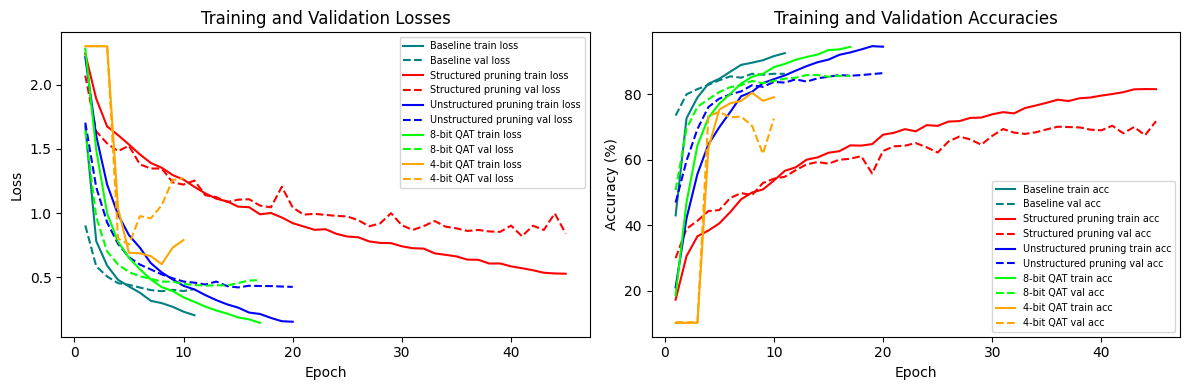

In [35]:
models = {
    'Baseline': {
        'train_losses': baseline_metrics[0],
        'val_losses':   baseline_metrics[2],
        'train_acc':    baseline_metrics[1],
        'val_acc':      baseline_metrics[3]
    },
    'Structured pruning': {
        'train_losses': sp_metrics[0],
        'val_losses':   sp_metrics[2],
        'train_acc':    sp_metrics[1],
        'val_acc':      sp_metrics[3]
    },
    'Unstructured pruning': {
        'train_losses': usp_metrics[0],
        'val_losses':   usp_metrics[2],
        'train_acc':    usp_metrics[1],
        'val_acc':      usp_metrics[3]
    },
    '8-bit QAT': {
        'train_losses': qat_8bit_metrics[0],
        'val_losses':   qat_8bit_metrics[2],
        'train_acc':    qat_8bit_metrics[1],
        'val_acc':      qat_8bit_metrics[3]
    },
    '4-bit QAT': {
        'train_losses': qat_4bit_metrics[0],
        'val_losses':   qat_4bit_metrics[2],
        'train_acc':    qat_4bit_metrics[1],
        'val_acc':      qat_4bit_metrics[3]
    }
}

plot_training_metrics(models)

## Comparison table

In [36]:
import pandas as pd

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Flatten each dictionary in the list
flat_data = [flatten_dict(item) for item in [baseline_result,
                                             sp_result, usp_result,
                                             qat_8bit_result, qat_4bit_result]]

# Create a DataFrame from the flattened data
df = pd.DataFrame(flat_data)


# print(df)
df

,technique,epoch,model_size,flops,acc,top1,top5,flops_original,flops_pruned,params_original,params_pruned,size_reduction
0,Baseline - CIFAR-10,11,532.57 MB,0.28 GFLOPs,86.30%,86.30%,99.80%,NaN,NaN,NaN,NaN,NaN
1,Structured Pruning - CIFAR-10,45,376.64 MB,0.20 GFLOPs,71.80%,71.80%,98.10%,19.68 GFLOPs,9.77 GFLOPs,139.61 Million,98.73 Million,NaN
2,Unstructured Pruning - CIFAR-10,20,532.57 MB,0.28 GFLOPs,86.50%,86.50%,99.70%,NaN,NaN,NaN,NaN,NaN
3,Quantization 8bit - CIFAR-10,17,133.42 MB,0.28 GFLOPs,85.70%,85.70%,99.60%,NaN,NaN,NaN,NaN,74.95%
4,Quantization 4bit - CIFAR-10,10,133.20 MB,0.28 GFLOPs,71.80%,71.80%,84.80%,NaN,NaN,NaN,NaN,74.99%


In [37]:
def get_quantized_weights_mapping(model):
    quantized_weights = {}
    import torch.nn.quantized as nnq
    for name, module in model.named_modules():
        if isinstance(module, (nnq.Conv2d, nnq.Linear)):
            quantized_weights[name] = module.weight().dequantize()
    return quantized_weights

def compute_model_metrics(model, quantized=False):
    if quantized:
        # Get dequantized weights from quantized modules.
        weights_mapping = get_quantized_weights_mapping(model)
        if weights_mapping:
            # Create a list of all dequantized weight tensors.
            all_weights = list(weights_mapping.values())
            total_params = sum(weight.numel() for weight in all_weights)
            l1_norm = sum(weight.abs().sum().item() for weight in all_weights)
            l2_norm = (sum((weight**2).sum().item() for weight in all_weights)) ** 0.5
            zero_params = sum((weight == 0).sum().item() for weight in all_weights)
            sparsity = zero_params / total_params
        else:
            total_params, l1_norm, l2_norm, sparsity = 0, 0, 0, 0
    else:
        total_params = sum(p.numel() for p in model.parameters())
        l1_norm = sum(p.abs().sum().item() for p in model.parameters())
        l2_norm = (sum((p**2).sum().item() for p in model.parameters())) ** 0.5
        zero_params = sum((p == 0).sum().item() for p in model.parameters())
        sparsity = zero_params / total_params
    return total_params, l1_norm, l2_norm, sparsity

def annotate_bars(ax, bars, baseline, fmt, is_sparsity=False, fs=8):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i == 0:
            annotation = fmt(height)
        else:
            if baseline == 0 and is_sparsity:
                annotation = fmt(height)
            else:
                improvement = ((baseline - height) / baseline * 100) if not is_sparsity else ((height - baseline) / baseline * 100)
                if abs(improvement) < 1e-6:
                    annotation = fmt(height)
                else:
                    annotation = f"{fmt(height)}\n({improvement:.2f}%)"
        ax.annotate(annotation,
                    xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                    ha='center', va='center', fontsize=fs, color='black')

def plot_weight_distributions(models, model_names, quantized_flags):
    n = len(models)
    fig, axs = plt.subplots(1, n, figsize=(3 * n, 2), sharex=True, sharey=True)
    if n == 1:
        axs = [axs]  # ensure axs is iterable if only one subplot

    for i, (model, name, is_quantized) in enumerate(zip(models, model_names, quantized_flags)):
        if is_quantized:
            weights_mapping = get_quantized_weights_mapping(model)
            if weights_mapping:
                all_weights = torch.cat([w.flatten() for w in weights_mapping.values()])
            else:
                print(f"No quantized weights found for {name}.")
                continue
        else:
            all_weights = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
        weights_np = all_weights.detach().cpu().numpy()
        weight_min, weight_max = np.percentile(weights_np, [1, 99])


        axs[i].hist(weights_np, bins=23, range=(weight_min, weight_max), density=True, alpha=0.7)
        axs[i].set_title(name, fontsize=10)
        axs[i].set_xlabel('Weight Value', fontsize=8)
        axs[i].set_ylabel('Density', fontsize=8)
        axs[i].tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    plt.show()

## Params, L1, L2 and Sparsity

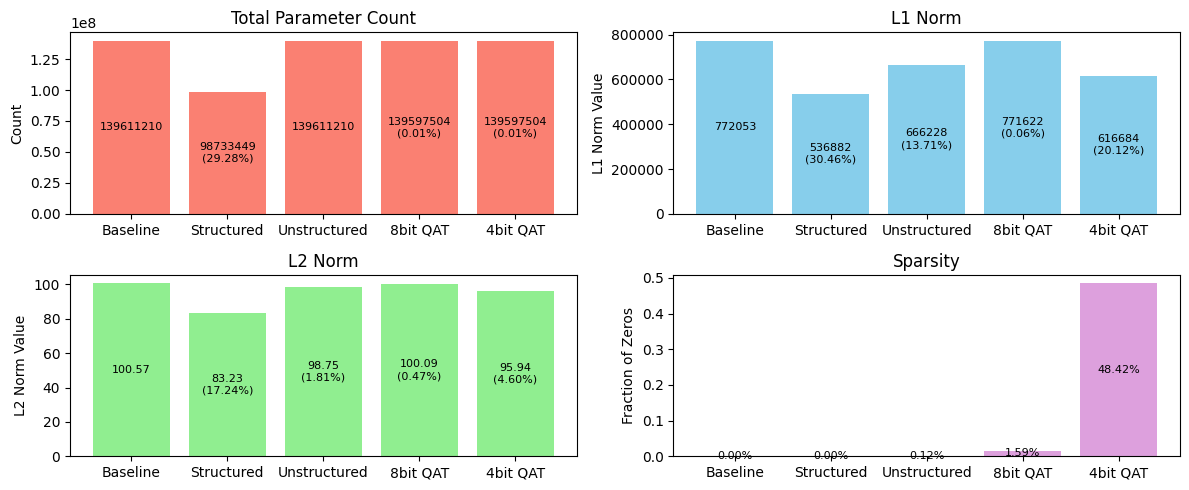

In [38]:
# Compute metrics for all models
baseline_params, baseline_l1, baseline_l2, baseline_sparsity = compute_model_metrics(baseline_cifar10)
structured_params, structured_l1, structured_l2, structured_sparsity = compute_model_metrics(sp_cifar10)
unstructured_params, unstructured_l1, unstructured_l2, unstructured_sparsity = compute_model_metrics(usp_cifar10)
quant8_params, quant8_l1, quant8_l2, quant8_sparsity = compute_model_metrics(qat_8bit_cifar10, True)   # 8-bit quantized model
quant4_params, quant4_l1, quant4_l2, quant4_sparsity = compute_model_metrics(qat_4bit_cifar10, True)   # 4-bit quantized model

# Create lists for plotting
models = ['Baseline', 'Structured', 'Unstructured', '8bit QAT', '4bit QAT']
param_counts = [baseline_params, structured_params, unstructured_params, quant8_params, quant4_params]
l1_norms = [baseline_l1, structured_l1, unstructured_l1, quant8_l1, quant4_l1]
l2_norms = [baseline_l2, structured_l2, unstructured_l2, quant8_l2, quant4_l2]
sparsities = [baseline_sparsity, structured_sparsity, unstructured_sparsity, quant8_sparsity, quant4_sparsity]

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

# --- Parameter Count ---
baseline_val = param_counts[0]
ax = axs[0, 0]
bars = ax.bar(models, param_counts, color='salmon')
ax.set_title('Total Parameter Count')
ax.set_ylabel('Count')
annotate_bars(ax, bars, baseline_val, lambda x: f'{x:.0f}')

# --- L1 Norm ---
baseline_val = l1_norms[0]
ax = axs[0, 1]
bars = ax.bar(models, l1_norms, color='skyblue')
ax.set_title('L1 Norm')
ax.set_ylabel('L1 Norm Value')
annotate_bars(ax, bars, baseline_val, lambda x: f'{x:.0f}')

# --- L2 Norm ---
baseline_val = l2_norms[0]
ax = axs[1, 0]
bars = ax.bar(models, l2_norms, color='lightgreen')
ax.set_title('L2 Norm')
ax.set_ylabel('L2 Norm Value')
annotate_bars(ax, bars, baseline_val, lambda x: f'{x:.2f}')

# --- Sparsity ---
baseline_val = sparsities[0]
ax = axs[1, 1]
bars = ax.bar(models, sparsities, color='plum')
ax.set_title('Sparsity')
ax.set_ylabel('Fraction of Zeros')
annotate_bars(ax, bars, baseline_val, lambda x: f'{x:.2%}', is_sparsity=True)

plt.tight_layout()
plt.show()

## Weight distributions

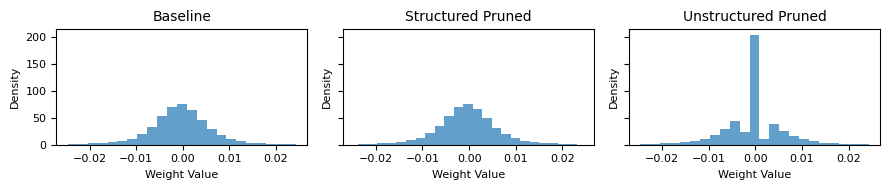

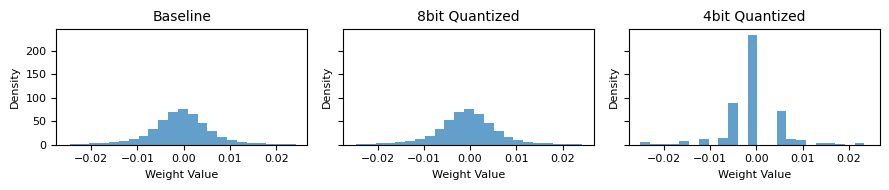

In [39]:
# Group 1: Baseline, Structured Pruned, Unstructured Pruned (all non-quantized)
group1_models = [baseline_cifar10, sp_cifar10, usp_cifar10]
group1_names = ["Baseline", "Structured Pruned", "Unstructured Pruned"]
group1_quantized_flags = [False, False, False]

plot_weight_distributions(group1_models, group1_names, group1_quantized_flags)

# Group 2: Baseline, 8bit Quantized, 4bit Quantized
group2_models = [baseline_cifar10, qat_8bit_cifar10, qat_4bit_cifar10]
group2_names = ["Baseline", "8bit Quantized", "4bit Quantized"]
group2_quantized_flags = [False, True, True]

plot_weight_distributions(group2_models, group2_names, group2_quantized_flags)